In [1]:
import os 
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#Prep:----------------------------------
#os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/share/run_05')
os.chdir('/work1/eilin/data/CLUSTERS_01/Archive_MA_12072018/stars_shortlist_share')
today = time.strftime("%d_%b_%Y", time.gmtime())
run = '05'
locs = [#('M67','M67_run_{}_cum_FFD.csv'.format(run),4.0),
        ('M44','M44_run_{}_cum_FFD.csv'.format(run),0.630),
       # ('NGC_1647','NGC_1647_run_{}_cum_FFD.csv'.format(run),0.145),
        ('Pleiades','Pleiades_run_{}_cum_FFD.csv'.format(run),0.125)]
frames = []
for (key, value,age) in locs:
    df = pd.read_csv(value,
                     usecols = ['Tmax','Tmin','alpha',
                                'alpha_err','beta','beta_err',
                                'minenerg','maxenerg','n_obj','nflares'],
                     )
    frames.append(df)
res = pd.concat(frames, keys=[x[2] for x in locs])
res = res.reset_index()
res = res.drop('level_1',axis=1)
res = res.rename(index=str, columns={'level_0':'age'})
ages = {4.3:'M67',0.630:'M44',0.145:'NGC_1647',0.125:'Pleiades'}
res['cluster'] = [ages[i] for i in res.age]
res = res.dropna(how='any')
#Transform alpha to conventional value
res.alpha = -res.alpha+1.
#res = res[(res.Tmax==7000) & (res.Tmin ==3000)]
#Prep end. ------------------------------
#res = res[res.nflares > 10]
res.Tmax[(res.age==0.12) & (res.Tmin == 3750.)]=4000.
res

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,age,Tmax,Tmin,alpha,alpha_err,beta,beta_err,maxenerg,minenerg,n_obj,nflares,cluster
0,0.630,7000,3000,1.883309,0.029874,30.585672,0.968304,3.104129e+33,5.000000e+28,740,204,M44
1,0.630,3249,3000,1.647115,0.063343,22.374382,2.053803,2.054954e+33,5.000000e+28,248,51,M44
2,0.630,3499,3250,1.775059,0.027776,26.619234,0.897893,3.053534e+33,5.000000e+28,139,74,M44
3,0.630,3749,3500,1.895825,0.059708,30.487996,1.932213,2.183478e+33,5.000000e+28,140,64,M44
4,0.630,4000,3750,1.977149,0.226573,32.242142,7.321139,4.416213e+32,5.000000e+28,73,8,M44
5,0.125,7000,3000,1.927043,0.015629,32.512192,0.508341,2.029237e+34,5.000000e+28,721,564,Pleiades
6,0.125,3249,3000,1.942259,0.024920,32.348700,0.806848,1.126300e+34,5.000000e+28,307,174,Pleiades
7,0.125,3499,3250,2.000070,0.032911,34.373933,1.069575,8.925924e+33,5.000000e+28,150,173,Pleiades
8,0.125,3749,3500,1.960301,0.036661,33.033657,1.193607,2.029237e+34,5.000000e+28,119,144,Pleiades
9,0.125,3999,3750,1.837601,0.086693,28.680420,2.835709,5.258586e+33,5.000000e+28,45,38,Pleiades


In [2]:
res = res[(res.Tmax-res.Tmin < 500) | (res.Tmax-res.Tmin > 3000)]
#res = res[res.Tmax != 5000]
#res = res[res.Tmax != 5500]
#res = res[res.Tmax != 4500]
res.Tmax[res.Tmax == 3999.] = 4000.
res = res.sort_values(by='Tmax')

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [3]:
from collections import OrderedDict
from matplotlib.transforms import blended_transform_factory

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

### Plot alpha and beta(t)

In [4]:
def colors(Tmin, Tmax):
    if Tmax < 7000.:
        c = {3000:linestyles['densely dashed'], 
             3250:linestyles['densely dotted'],
             3500:linestyles['densely dashdotted'],
             3750:linestyles['densely dashdotdotted']}
        return c[Tmin]
    else: 
        return '-'
rcParams.update({'errorbar.capsize': 20})
# import pylab as plt
# params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
# plt.rcParams.update(params)
import matplotlib.pylab as pl
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,7),sharex=True)
for label, df in res.groupby(['Tmax','Tmin']):
    df.plot(x='age',y='beta',yerr='beta_err',
      kind='line', ax=ax2,legend=False,
                 markersize=10,linewidth=5,marker='o',alpha=0.75,
                # label='{}-{} K'.format(int(label[1]),int(label[0])),
                 linestyle=colors(label[1],label[0]))
    print(label[0])
    df.plot(x='age',y='alpha',yerr='alpha_err',
                 kind='line', ax=ax1,
                 markersize=10,linewidth=5,marker='o',
                 label='{}-{} K'.format(int(label[1]),int(label[0])), 
                 linestyle=colors(label[1],label[0]),
                 alpha=0.75,
           )
ax1.legend(bbox_to_anchor=(0.6,0.27))

ax1.set_xlabel('age (Gyr)')
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel('age (Gyr)')
ax2.set_ylabel(r'$\log\beta$')
plt.xlim(0,0.8)


plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/alphabeta.png',dpi=300)


3249.0
3499.0
3749.0
4000.0
7000.0


RuntimeError: LaTeX was not able to process the following string:
b'lp'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016/TeX Live for opensuse.org) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d25dddb648b210abf96e1bd25f859bc5.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 51 language(s) loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))
(/usr/share/texmf/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/psnfss/helvet.sty
(/usr/share/texmf/tex/latex/graphics/keyval.sty))
(/usr/share/texmf/tex/latex/base/textcomp.sty
(/usr/share/texmf/tex/latex/base/ts1enc.def))

! LaTeX Error: File `cmbright.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [papersize={72in,72in},body={70in,70in},margin={1in,1in}]{geo...

No pages of output.
Transcript written on d25dddb648b210abf96e1bd25f859bc5.log.


RuntimeError: LaTeX was not able to process the following string:
b'lp'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016/TeX Live for opensuse.org) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d25dddb648b210abf96e1bd25f859bc5.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 51 language(s) loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))
(/usr/share/texmf/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/psnfss/helvet.sty
(/usr/share/texmf/tex/latex/graphics/keyval.sty))
(/usr/share/texmf/tex/latex/base/textcomp.sty
(/usr/share/texmf/tex/latex/base/ts1enc.def))

! LaTeX Error: File `cmbright.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [papersize={72in,72in},body={70in,70in},margin={1in,1in}]{geo...

No pages of output.
Transcript written on d25dddb648b210abf96e1bd25f859bc5.log.


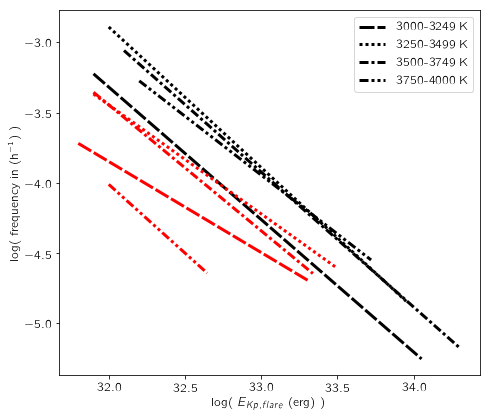

In [37]:
#fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4),sharex=True)

plt.figure(figsize=(7,6))
pleiades = res[res.age==0.125]
tmin = {3249.:31.9,
        3499.:32.,
        3749.:32.1,
        4000.:32.2,
        7000.:32.1,}
for i, row in pleiades.iterrows():
    x = np.linspace(tmin[row.Tmax], np.log10(row.maxenerg),30)
    b = 10**(row.beta)/(dur.dur[(dur.Tmax==row.Tmax) & (dur.age==0.63)]*365*24)
    b = np.log10(b).values
    y = b - (row.alpha-1.)*x
    plt.plot(x,y,linestyle=colors(row.Tmin,row.Tmax),c='k',linewidth=3,label='{}-{} K'.format(int(row.Tmin),int(row.Tmax)))
m44 = res[res.age==0.63]
tmin = {3249.:31.8,
        3499.:31.9,
        3749.:31.9,
        4000.:32.,
        7000.:31.9,}
for i, row in m44.iterrows():
    x = np.linspace(tmin[row.Tmax], np.log10(row.maxenerg),30)
    b = 10**(row.beta)/(dur.dur[(dur.Tmax==row.Tmax) & (dur.age==0.63)]*365*24)
    b = np.log10(b).values
    y = b - (row.alpha-1.)*x
    plt.plot(x,y,linestyle=colors(row.Tmin,row.Tmax),c='red',linewidth=3,)
plt.legend()#bbox_to_anchor=(0.6,0.27))

plt.xlabel('log( $E_{Kp,flare}$ (erg) )')
plt.ylabel(r'log( frequency in (h$^{-1}$) )')
# ax2.set_xlabel('log(energy in erg)')
# ax2.set_ylabel(r'log(frequency in h$^{-1}$)')
plt.tight_layout()
plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/slopes.png',dpi=300)


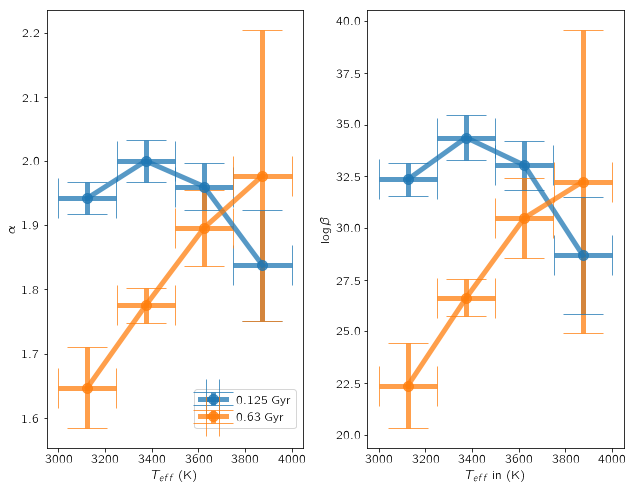

In [40]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,7),sharex=True)
res = res[res.Tmax != 7000]

for label, df in res.groupby(['age']):
    df = df.sort_values(by='Tmax')
    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df.plot(x='midTbin',y='beta',yerr='beta_err',xerr='Terr',
      kind='line', ax=ax2,legend=False,
                 markersize=10,linewidth=5,marker='o',alpha=0.75,
            label='{} Gyr'.format(label),
                       )
    
    df.plot(x='midTbin',y='alpha',yerr='alpha_err',xerr='Terr',
                 kind='line', ax=ax1,
                 markersize=10,linewidth=5,marker='o',
                label='{} Gyr'.format(label),
                 alpha=0.75,
           )
ax1.legend(bbox_to_anchor=(0.55,0.15))

ax1.set_xlabel('$T_{eff}$ (K)')
ax1.set_ylabel(r'$\alpha$')
ax2.set_xlabel('$T_{eff}$ in (K)')
ax2.set_ylabel(r'$\log\beta$')

plt.tight_layout()
plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/alphabetaofT.png',dpi=300)
#.format(today)

### Plot total energy, total number of flares per cluster

In [4]:
os.getcwd()

'/work1/eilin/data/CLUSTERS_01/Archive_MA_12072018/stars_shortlist_share'

In [6]:
#merge detection thresholds
threshs = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/run_{}_median_detection_thresholds.csv'.format(run))

value_vars = ['Pleiades','M44','M67']
id_vars = ['Tmin','Tmax']
t = pd.melt(threshs, value_vars=value_vars, var_name='cluster',
            value_name='threshold', id_vars=id_vars)
t

,Tmin,Tmax,cluster,threshold
0,3000,3249,Pleiades,1.234378e+32
1,3250,3499,Pleiades,1.726234e+32
2,3500,3749,Pleiades,1.845931e+32
3,3750,4000,Pleiades,2.435808e+32
4,3000,7000,Pleiades,1.768141e+32
5,3000,3249,M44,3.426318e+32
6,3250,3499,M44,1.777936e+32
7,3500,3749,M44,1.123365e+32
8,3750,4000,M44,1.052825e+32
9,3000,7000,M44,1.987380e+32


In [9]:
#os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist')

# locs2 = [('Pleiades','share/run_05/clusterenergies_Pleiades.csv'.format(run),0.120),
#          ('M44','share/run_05/clusterenergies_M44.csv'.format(run),0.8),
#          ('M67','share/run_05/clusterenergies_M67.csv'.format(run),4.0)]
Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orangered'),
         (3500.0,3749.0,'gold'),(3750.0,4000.0,'c'),(3000.0,7000.0,'black')]
#Tlims = [(3000.0, 7000.0,'blue')]
dats = []
for Tmin, Tmax, color in Tlims:
    locs2 = [('Pleiades','clusterenergies_Pleiades_run_05_{}_{}.csv'.format(Tmin,Tmax),0.125),
             ('M44','clusterenergies_M44_run_05_{}_{}.csv'.format(Tmin,Tmax),0.63),
             ('M67','clusterenergies_M67_run_05_{}_{}.csv'.format(Tmin,Tmax),4.3)]
    for (name, value, age) in locs2:
        try:
            df = pd.read_csv(value,
                         usecols = ['clustered','clusterederr','clusterenergy',
                                    'clusterenergy_err','rel_energ_err','Teff',
                                    'stars_in_bin','Tmin','Tmax','L_bol','L_bol_err',
                                    'count_true','energ_true'],
                         )
            df['cluster'] = name
            
        except (FileNotFoundError, OSError):
            print('Nothing in {}-{} for {}'.format(Tmin,Tmax,name))
            continue
        #select color bin:
        print(df.shape)
        df = df[(df.Tmin == Tmin) & (df.Tmax == Tmax)]
        df = df[df.count_true < 5.]
        
        
        df = df.dropna(how='any')
        print(df.shape)
        if df.shape[0] == 0:
            print('No high probability events.')
            continue
        detthr = t[(t.Tmin==Tmin) & (t.Tmax==Tmax)].threshold.max()
        df = df[df.energ_true > detthr]
        #if (df.stars_in_bin != df.stars_in_bin.iloc[0]).any(): 
         #   raise ValueError('The number of stars in your bin is ambiguous.')
        #normalization constant
        if df.shape[0] == 0:
            print('No high energy events.')
            continue
        n_stars = df.stars_in_bin.iloc[0]
        FAerr = np.sqrt( df.clusterenergy_err**2 + ( df.energ_true * df.L_bol_err /  df.L_bol )**2 ) /  df.L_bol
        dats.append([ age, n_stars, detthr,
                    np.sqrt((df.clusterenergy_err**2).sum())/n_stars,
                    df.energ_true.sum()/n_stars, 
                    df.shape[0]/n_stars,
                    df.shape[0],
                    Tmin,Tmax,
                    (df.energ_true/df.L_bol).sum()/n_stars,
                     np.sqrt((FAerr**2).sum())/n_stars,])
dats = np.asarray(dats) 
data = pd.DataFrame(dats, columns=['age','n_stars','threshold',
                                   'tot_en_err','tot_en',
                                   'tot_flares_p_star','tot_flares',
                                   'Tmin','Tmax','FA','FA_err'])
for col in data.columns.values:
    if col!= 'cluster':
        data[col] = data[col].astype('float')
dur = pd.read_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/dur.csv')
print(dur)
data = data.merge(dur, how='left', on=['Tmin','Tmax','age'])
data['dursec'] = data.dur*365*24*60*60
data['FA'] = data.FA/data.dursec
data['FA_err'] = data.FA_err/data.dursec
data['tot_flares_p_yr'] = data.tot_flares/data.dur
data['tot_flares_p_yr_err'] = np.sqrt(data.tot_flares)/data.dur
data.sort_values(by='age')




data.to_csv('/work1/eilin/appaloosa/appaloosa/stars_shortlist/share/all_FAFR.csv')

(174, 14)
(174, 14)
(51, 14)
(51, 14)
Nothing in 3000.0-3249.0 for M67
(173, 14)
(173, 14)
(73, 14)
(73, 14)
Nothing in 3250.0-3499.0 for M67
(144, 14)
(144, 14)
(64, 14)
(64, 14)
Nothing in 3500.0-3749.0 for M67
(45, 14)
(45, 14)
(8, 14)
(8, 14)
No high energy events.
(2, 14)
(2, 14)
(564, 14)
(564, 14)
(204, 14)
(204, 14)
(4, 14)
(4, 14)
    Tmin  Tmax    age   dur100      dur
0   3000  7000  0.125  122.014  103.712
1   3000  3249  0.125   51.940   44.149
2   3250  3499  0.125   25.390   21.582
3   3500  3749  0.125   20.150   17.128
4   3750  4000  0.125    8.800    7.480
5   3000  7000  0.630  131.200  111.520
6   3000  3249  0.630   43.980   37.383
7   3250  3499  0.630   24.600   20.910
8   3500  3749  0.630   24.820   21.097
9   3750  4000  0.630   12.950   11.008
10  3000  7000  4.300   31.560   26.826
11  3000  3249  4.300    0.000    0.000
12  3250  3499  4.300    0.000    0.000
13  3500  3749  4.300    1.597    1.357
14  3750  4000  4.300    9.050    7.693


In [41]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(13,4))
time = np.arange(0.12,4,0.01)
skum1 = 0.00000005*np.sqrt(1/time)
skumno1 = 0.0005/time
skum2 = 0.01*np.sqrt(1/time)
skumno = 1/time
for label, df in data.groupby(['Tmax','Tmin']):
    df = df.sort_values(by='age')

    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)

    df.plot(x='age',y='FA',yerr='FA_err',
                 kind='line', ax=ax1,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,loglog=True,
                  linestyle=colors(label[1],label[0]),legend=False,)
    df.plot(x='age',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax2,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,legend=False,loglog=True,#label='{:.0f}-{:.0f} K'.format(label[1],label[0]),
                 #label='{:.0f}-{:.0f} K'.format(label[1],label[0]), 
                    linestyle=colors(label[1],label[0]),)
    df.plot(x='age',y='FA_FR',yerr='FA_FR_err',
                 kind='line', ax=ax3,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,loglog=True,legend=False,
             linestyle=colors(label[1],label[0]),
                 )
           
    print(label[0])
A = np.power(10,np.arange(-3,3,0.5))
B = np.power(10,np.arange(-1.3,3,0.35))
for a in A[5:]:
    ax1.plot(time, a*skum1,linewidth=2,linestyle=linestyles['loosely dotted'],color='k',alpha=0.6)#,label=r'$t^{-1/2}$')   
for a in B[6:-3]:    
    ax2.plot(time, a*skum2,linewidth=2,linestyle=linestyles['loosely dotted'],color='k',alpha=0.6,) 
#ax2.plot(time, skumno,linewidth=2,linestyle='dashed',color='k') 
#ax1.plot(time, skumno1,linewidth=2,linestyle='dashed',color='k') 
ax1.set_xlabel('age (Gyr)')
ax2.set_xlabel('age (Gyr)')
ax3.set_xlabel('age (Gyr)')
ax3.set_ylabel(r'FA per flare')
ax1.set_ylabel(r'FA')# in erg$\cdot$yr$^{-1}$')
ax2.set_ylabel(r'FR (yr$^{-1}$)')
# plt.text(x=0.11,y=2e32,s='Pleiades')
# plt.text(x=0.14,y=1e32,s='NGC 1647')
# plt.text(x=0.6,y=2e32,s='Praesepe')
# plt.text(x=3.4,y=4e32,s='M67')
#ax2.legend()
plt.tight_layout()
#plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/FAFR1e33.png',dpi=300)

3249.0
3499.0
3749.0
4000.0
7000.0


RuntimeError: LaTeX was not able to process the following string:
b'lp'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016/TeX Live for opensuse.org) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./d25dddb648b210abf96e1bd25f859bc5.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 51 language(s) loaded.
(/usr/share/texmf/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texmf/tex/latex/base/size10.clo))
(/usr/share/texmf/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/psnfss/helvet.sty
(/usr/share/texmf/tex/latex/graphics/keyval.sty))
(/usr/share/texmf/tex/latex/base/textcomp.sty
(/usr/share/texmf/tex/latex/base/ts1enc.def))

! LaTeX Error: File `cmbright.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.9 \usepackage
               [papersize={72in,72in},body={70in,70in},margin={1in,1in}]{geo...

No pages of output.
Transcript written on d25dddb648b210abf96e1bd25f859bc5.log.


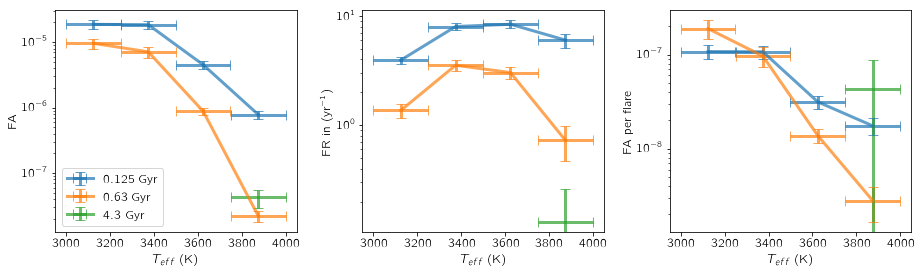

In [57]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(13,4))

data = data[data.Tmax != 7000.]
for label, df in data.groupby(['age']):
    df = df.sort_values(by='Tmax')

    df['midTbin'] =(df.Tmax+df.Tmin)/2
    df['Terr'] = df.Tmax-df.midTbin
    df['FA_FR'] =df.FA/df.tot_flares
    df['FA_FR_err'] =1/(df.tot_flares)*np.sqrt((df.FA_FR)**2 * df.tot_flares + df.FA_err**2)
    df.plot(x='midTbin',y='FA',yerr='FA_err',xerr='Terr',
                 kind='line', ax=ax1,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,logy=True,
                 label='{} Gyr'.format(label))#, color=colors(label[1],label[0]))
    df.plot(x='midTbin',y='tot_flares_p_yr',yerr='tot_flares_p_yr_err',
                 kind='line', ax=ax2,linewidth=3,alpha=0.7,xerr='Terr',
                 markersize=100,capsize=5,legend=False,logy=True,
                 #label='{:.0f}-{:.0f} K'.format(label[1],label[0]), 
                    #color=colors(label[1],label[0]),
           )
    df.plot(x='midTbin',y='FA_FR',yerr='FA_FR_err',xerr='Terr',
                 kind='line', ax=ax3,linewidth=3,alpha=0.7,
                 markersize=100,capsize=5,logy=True,legend=False
                 )
           
   # print(label[0])

#ax2.plot(time, skumno,linewidth=2,linestyle='dashed',color='k') 
#ax1.plot(time, skumno1,linewidth=2,linestyle='dashed',color='k') 
ax1.set_xlabel(r'$T_{eff}$ (K)')
ax2.set_xlabel(r'$T_{eff}$ (K)')
ax3.set_xlabel(r'$T_{eff}$ (K)')
ax1.set_ylabel(r'FA ')# in erg$\cdot$yr$^{-1}$')
ax2.set_ylabel(r'FR in (yr$^{-1}$)')
ax3.set_ylabel(r'FA per flare')
# plt.text(x=0.11,y=2e32,s='Pleiades')
# plt.text(x=0.14,y=1e32,s='NGC 1647')
# plt.text(x=0.6,y=2e32,s='Praesepe')
# plt.text(x=3.4,y=4e32,s='M67')
ax1.legend()
plt.tight_layout()
plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/results/FAFRofT.png',dpi=300)

3000.0
3000.0
3250.0
3500.0
3750.0


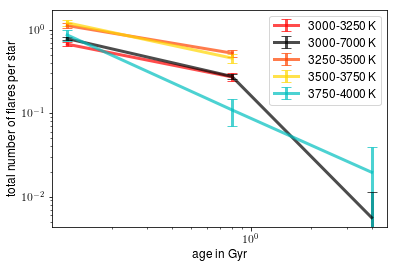

In [33]:
fig, ax = plt.subplots(figsize=(6,4))
for label, df in data.groupby(['Tmin','Tmax']):
    df = df.sort_values(by='age')
    df.plot(x='age',y='tot_flares_p_star',yerr='tot_flares_p_star_err',
                 kind='line', ax=ax,capsize=5,
                 markersize=50,alpha=0.7,
                linewidth=3,loglog=True,
                 #linestyle='dashed',
                 label='{:.0f}-{:.0f} K'.format(label[0],label[1]), color=colors(label[0],label[1]))
    print(label[0])
plt.xlabel('age in Gyr')
plt.ylabel('total number of flares per star')
#plt.ylim(5e-3,20)
# plt.text(x=0.11,y=30,s='Pleiades')
# plt.text(x=0.14,y=18,s='NGC 1647')
# plt.text(x=0.7,y=16,s='Praesepe')
# plt.text(x=3.55,y=2.5,s='M67')
plt.legend()
plt.savefig('share/dated/{}_tot_flares_color_bins_full.jpg'.format(today),dpi=300)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
#print(os.getcwd())
os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist')
Tmin,Tmax=3000.0,7000.0

locs2 = [('Pleiades','share/run_05/clusterenergies_Pleiades_run_05_{}_{}.csv'.format(Tmin,Tmax),0.120,'green'),
         ('M44','share/run_05/clusterenergies_M44_run_05_{}_{}.csv'.format(Tmin,Tmax),0.8,'orange'),
         ('M67','share/run_05/clusterenergies_M67_run_05_{}_{}.csv'.format(Tmin,Tmax),4.0,'blue')]
for (name, value, age,color) in locs2:
    vars()[name] = pd.read_csv(value,
                     usecols = ['clustered','clusterederr','clusterenergy',
                                'clusterenergy_err','rel_energ_err','Teff',
                                'stars_in_bin','Tmin','Tmax','L_bol','L_bol_err',
                                'count_true','energ_true','EPIC'],
                     )
#M67=M67[M67.count_true==1.6]
#M44[M44.Teff > 4000].count()#5170K 3 flares???
#Pleiades[Pleiades.Teff > 4000].sort_values(by='Teff').count()#4620,5170,4410,
#M44.groupby('EPIC').count().shape

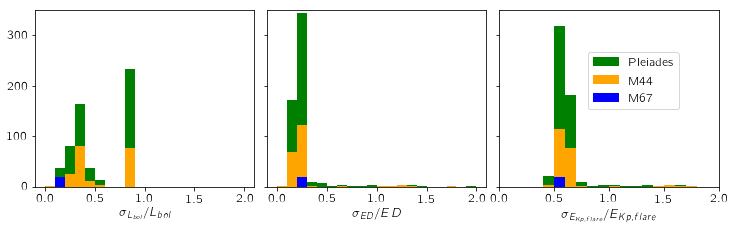

In [14]:

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'jet'
#import matplotlib.pylab as pl
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=13)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1,sharey=True,figsize=(10,3),squeeze=True)
for (name, value, age,color) in locs2:
    x = vars()[name]
    if name=='M67': a=20
    else: a=1
    ax1.hist(np.repeat(x.L_bol_err/x.L_bol,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax1.set_xlabel(r'$\sigma _{L_{bol}} / L_{bol}$')
    ax2.hist(np.repeat(x.clusterederr/x.clustered,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax2.set_xlabel(r'$\sigma _{ED} / ED$')
    ax3.hist(np.repeat(x.rel_energ_err,a),label=name,range=(0,2),bins=20,
             histtype='barstacked',linewidth=2,stacked=True,color=color,
            )
    ax3.set_xlabel(r'$\sigma _{E_{Kp,flare}} /E_{Kp,flare}$')
plt.ylim(.1,350)
plt.xlim(0,2)

plt.legend(bbox_to_anchor=(0.85,0.80))
fig.tight_layout(pad=0)
plt.savefig('/home/ekaterina/Documents/Flares_in_Clusters_Paper/pic-dump/relerr.png',dpi=300)

In [177]:
for (name, value, age) in locs2:
    x = vars()[name]
    x = x[x.count_true < 5.]
    print(r'{:8} mean relative error on ED         is {:.2f}$\pm${:.2f}.'.format(name, (x.clusterederr/x.clustered).mean(),(x.clusterederr/x.clustered).std()))
    print(r'{:8} mean relative error on energy     is {:.2f}$\pm${:.2f}.'.format(name, (x.rel_energ_err).mean(),(x.rel_energ_err).std()))
    print(r'{:8} mean relative error on luminosity is {:.2f}$\pm${:.2f}.'.format(name, (x.L_bol_err/x.L_bol).mean(),(x.L_bol_err/x.L_bol).std()))

Pleiades mean relative error on ED         is 0.29$\pm$0.52.
Pleiades mean relative error on energy     is 0.66$\pm$0.52.
Pleiades mean relative error on luminosity is 0.55$\pm$0.27.
M44      mean relative error on ED         is 0.26$\pm$0.24.
M44      mean relative error on energy     is 0.63$\pm$0.24.
M44      mean relative error on luminosity is 0.53$\pm$0.27.
M67      mean relative error on ED         is 0.21$\pm$nan.
M67      mean relative error on energy     is 0.51$\pm$nan.
M67      mean relative error on luminosity is 0.18$\pm$nan.


In [182]:
Pleiades.sort_values(by='energ_true').tail()

,L_bol,L_bol_err,Teff,Tmax,Tmin,clustered,clusterederr,clusterenergy,clusterenergy_err,count_true,energ_true,stars_in_bin,rel_energ_err
563,2.422876e+29,8.089374e+28,3500.0,7000.0,3000.0,7724.401963,1711.638107,6.884107e+33,3.765324e+33,4.000000,2.029237e+34,723,0.546959
564,1.426695e+29,4.763377e+28,3410.0,7000.0,3000.0,2479.392822,602.477609,1.607760e+33,1.089017e+33,2.666667,1.228252e+35,723,0.677351
565,1.426695e+29,4.763377e+28,3410.0,7000.0,3000.0,810.774986,779.767652,5.257461e+32,7.340010e+32,2.666667,1.228252e+35,723,1.396113
566,1.426695e+29,4.763377e+28,3410.0,7000.0,3000.0,1110.087082,303.988372,7.198347e+32,5.097862e+32,2.666667,1.228252e+35,723,0.708199
567,1.796103e+34,3.101760e+33,6040.0,7000.0,3000.0,184.878830,36.472844,2.792400e+34,1.343557e+34,3.888889,1.462172e+35,723,0.481148


In [15]:
1/178/80*365


0.02563202247191011

In [10]:
0.22/4


0.055

In [110]:
0.06/1.77

0.03389830508474576

In [12]:
dur


,Tmin,Tmax,age,dur100,dur
0,3000,7000,0.12,122.014,103.712
1,3000,3249,0.12,51.940,44.149
2,3250,3499,0.12,25.390,21.582
3,3500,3749,0.12,20.150,17.128
4,3750,4000,0.12,8.800,7.480
5,3000,7000,0.80,131.200,111.520
6,3000,3249,0.80,43.980,37.383
7,3250,3499,0.80,24.600,20.910
8,3500,3749,0.80,24.820,21.097
9,3750,4000,0.80,12.950,11.008


In [11]:
import pandas as pd
import glob
cluster = 'M44'
l = '/home/ekaterina/Documents/appaloosa/stars_shortlist/share/run_05/{0}_parameter2.csv'.format(cluster)

print(glob.glob(l))
if glob.glob(l) != []:
    specs = pd.read_csv(l, index_col='EPIC')
specs.columns.values

['/home/ekaterina/Documents/appaloosa/stars_shortlist/share/run_05/M44_parameter2.csv']


array(['Unnamed: 0', 'angDist', 'gmag', 'rmag', 'imag', 'zmag', 'ymag',
       'J', 'H', 'K', 'RAJ2000', 'DEJ2000', 'spec_class', 'T', 'logT',
       'BCv', 'Mv', 'logL', 'B-V', 'Bt-Vt', 'V-G', 'U-B', 'V-Rc', 'V-Ic',
       'V-Ks', 'J-H', 'H-K', 'Ks-W1', 'W1-W2', 'W1-W3', 'W1-W4', 'Msun',
       'logAge', 'b-y', 'M_J', 'M_Ks', 'Mbol', 'i-z', 'z-Y', 'R_Rsun',
       '#SpT.1', 'lum_class', 'u_g', 'g_r', 'r_i', 'i_z', 'z_J', 'J_H',
       'H_K', 'Jmag_abs', 'T_err', 'R_Rsun_err', 'Mbol_err', '72',
       'L_quiet', 'L_quiet_bol', 'L_quiet_err', 'L_quiet_bol_err', 'g_i',
       'J_K', 'r_z', 'g_z', 'J-K'], dtype=object)

In [13]:
s = specs[['H', 'J', 'K','gmag', 'imag', 'rmag', 'ymag', 'zmag']]

In [4]:
params=pd.read_csv('/home/ekaterina/Documents/appaloosa/stars_shortlist/static/merged_specs.csv')
print(params.columns.values)

['Unnamed: 0' 'spec_class' 'T' 'logT' 'BCv' 'Mv' 'logL' 'B-V' 'Bt-Vt'
 'V-G' 'U-B' 'V-Rc' 'V-Ic' 'V-Ks' 'J-H' 'H-K' 'Ks-W1' 'W1-W2' 'W1-W3'
 'W1-W4' 'Msun' 'logAge' 'b-y' 'M_J' 'M_Ks' 'Mbol' 'i-z' 'z-Y' 'R_Rsun'
 '#SpT.1' 'lum_class' 'u_g' 'g_r' 'r_i' 'i_z' 'z_J' 'J_H' 'H_K' 'Jmag_abs']


In [14]:
s['J-H'] = s.J - s.H
s['H-K'] = s.H - s.K
s['i-z'] = s.imag - s.zmag
s['z-Y'] = s.zmag - s.ymag

s['g-r'] = s.gmag - s.rmag
s['r-i'] = s.rmag - s.imag
s['i-z'] = s.imag - s.zmag
s['z-J'] = s.zmag - s.J

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [15]:
s.count()

H       739
J       740
K       740
gmag    732
imag    739
rmag    735
ymag    734
zmag    736
J-H     739
H-K     739
i-z     736
z-Y     734
g-r     732
r-i     734
z-J     736
dtype: int64

In [9]:
k = pd.read_csv('/home/ekaterina/Documents/Matching_Catalogs/KICEPIC.csv')
k.columns.values
#k.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


array(['angDist', 'id', 'k2_ra', 'k2_dec', 'hip', 'tyc', 'ucac',
       'twomass', 'sdss', 'objtype', 'kepflag', 'stpropflag', 'pmRA',
       'e_pmRA', 'pmDEC', 'e_pmDEC', 'plx', 'e_plx', 'bmag', 'e_bmag',
       'vmag', 'e_vmag', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag',
       'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'jmag', 'e_jmag',
       'hmag', 'e_hmag', 'kmag', 'e_kmag', 'kp', 'teff', 'ep_teff',
       'em_teff', 'logg', 'ep_logg', 'em_logg', 'feh', 'ep_feh', 'em_feh',
       'rad', 'ep_rad', 'em_rad', 'mass', 'ep_mass', 'em_mass', 'rho',
       'ep_rho', 'em_rho', 'd', 'ep_d', 'em_d', 'ebv', 'ep_ebv', 'em_ebv',
       'nomad', 'mflg', 'prox', 'k2_avail_flag', 'KIC', 'RA', 'Dec',
       'umag.1', 'gmag.1', 'rmag.1', 'imag.1', 'zmag.1', 'Jmag', 'Hmag',
       'Kmag', 'kepmag', 'pmRA.1', 'pmDec', 'sg', 'v', 'cq', 'aq', 'fc'],
      dtype=object)

In [11]:
k.kp

0         7.815
1        12.795
2        13.723
3         9.500
4        15.309
5        12.271
6        14.540
7        12.938
8        13.360
9         7.083
10       10.668
11       10.733
12       13.666
13       11.076
14       14.810
15       16.128
16       11.694
17        9.267
18        9.196
19        7.991
20        7.623
21       11.854
22       16.283
23       10.280
24       10.270
25       11.433
26        8.849
27       13.296
28       13.825
29       14.400
          ...  
51463    17.486
51464    16.266
51465    16.996
51466    16.452
51467    14.322
51468    17.578
51469    15.205
51470    14.905
51471    13.332
51472    16.776
51473    17.334
51474    17.280
51475    15.787
51476    17.782
51477    15.053
51478    16.409
51479    13.985
51480    16.060
51481    15.051
51482    16.119
51483    15.633
51484    15.189
51485    16.352
51486    14.702
51487    14.337
51488    16.028
51489    14.595
51490    15.612
51491    17.802
51492    15.289
Name: kp, Length: 51493,

In [6]:
k = k[['KIC','id','twomass']]

In [7]:
k.head()

,KIC,id,twomass
0,11249,211044267,03472682+2340421
1,12704,211046240,03470853+2342389
2,12705,211048126,03470943+2344318
3,12706,211050523,03470988+2346568
4,11250,211044898,03475424+2341178


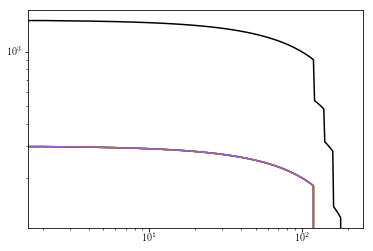

In [14]:
x=np.linspace(0,200,100)
plt.figure()
y1 = np.append(300-x[:-i],[0]*i)
plt.plot(x,y1)
y = y1.copy()
for i in np.arange(10,50,10):

    y = y + np.append(300-x[:-i],[0]*i)
    plt.plot(x,y1)
plt.yscale('log')
plt.xscale('log')
plt.plot(x,y,color='k')

In [16]:
2**(-2.5)*10



1.7677669529663689